In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

import sys
sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')

In [4]:
import time
from math import ceil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.tensorboard
import numpy as np
import yaml
from make_waveform import BatchedLightSimulation, mod0_sampler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange

device = torch.device('cuda:0')

2025-06-23 13:19:53.207945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750709993.241387 4189863 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750709993.251335 4189863 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 13:19:53.292984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


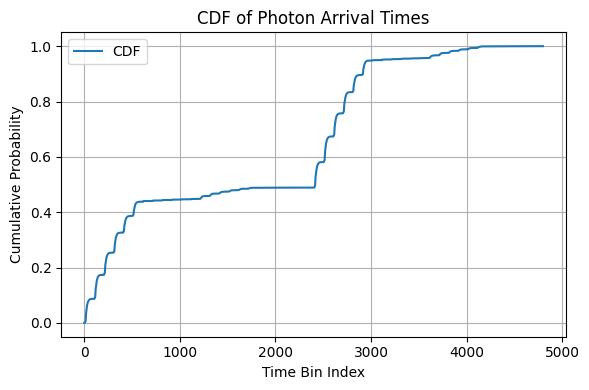

In [6]:
from make_waveform import *

sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml").to(device) # gives input / "true" 2D timing distribution

# 
nphoton = 16
nbatch = 1
inputs = mod0_sampler.batch_sample(nphoton=nphoton, nbatch=nbatch)

# CDF used by mod0_sampler
data_path = 'data/lightLUT_Mod0_06052024_32.1.16_time_dist_cdf.npz'
data = np.load(data_path)
plt.figure(figsize=(6, 4))
plt.plot(data["cdf"], label='CDF')
plt.xlabel("Time Bin Index")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Photon Arrival Times")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
'''
def scintillation_model(self, time_tick: torch.Tensor, relax_cut: bool=True) -> torch.Tensor:
        """
        Calculates the fraction of scintillation photons emitted
        during time interval `time_tick` to `time_tick + 1`

        Args:
            time_tick (torch.Tensor): time tick relative to t0
            relax_cut (bool): whether to apply the relaxing cut for differentiability

        Returns:
            torch.Tensor: fraction of scintillation photons
        """

        singlet_fraction = torch.sigmoid(self.singlet_fraction_logit * self.nominal_singlet_fraction_logit)
        tau_s = torch.pow(10, self.log_tau_s * self.nominal_log_tau_s)
        tau_t = torch.pow(10, self.log_tau_t * self.nominal_log_tau_t)
        t = time_tick * self.light_tick_size

        p1 = (
            singlet_fraction
            * torch.exp(-t / tau_s)
            * (1 - torch.exp(-self.light_tick_size / tau_s))
        )
        p3 = (
            (1 - singlet_fraction)
            * torch.exp(-t / tau_t)
            * (1 - torch.exp(-self.light_tick_size / tau_t))
        )
        
        if relax_cut:
            return (p1 + p3) / (1 + torch.exp(-self.k * t))

        return (p1 + p3) * (t >= 0).float()
'''

In [118]:
'''
for each photon:
    sample arrival time distribution for appopriate state (triplet/singlet)
'''

def scintillation_model_sampling(num_photons: int, bin_units: int, time_ticks: torch.Tensor) -> torch.Tensor:
    '''
    Parameters:
        - time_tick: tensor of times in microseconds
    Returns:
        - tensor storing photon hit counts corresponding to each time tick

    '''
    # decide whether each photon is singlet or triplet
    is_singlet = torch.rand(num_photons) < nominal_singlet_fraction

    # sample the scinitillation emission delay
    singlet_delays = torch.distributions.Exponential(1.0 / tau_s).sample([num_photons])
    triplet_delays = torch.distributions.Exponential(1.0 / tau_t).sample([num_photons])
    emission_delays = torch.where(is_singlet, singlet_delays, triplet_delays)

    # scaled_bins = bin_units * time_ticks

    # should return counts for each tick: 0, 1, ..., 16000 where each tick is 0.001 microseconds
    # delay_counts = torch.histc(emission_delays, bins=scaled_bins.numel() - 1, min=scaled_bins[0].item(), max=scaled_bins[-1].item())

    # Calculate bin edges from time ticks (assumes time_ticks are bin centers)
    bin_width = bin_units  # microseconds per bin
    bin_centers = time_ticks * bin_width
    bin_edges = bin_centers[:-1] + bin_width / 2
    bin_edges = torch.cat([
        bin_centers[:1] - bin_width / 2,  # left edge of first bin
        bin_edges
    ])

    # Use torch.bucketize to assign each delay to a bin
    bin_indices = torch.bucketize(emission_delays, bin_edges) - 1  # bins start at index 0

    # Count photons per bin using bincount
    delay_counts = torch.bincount(bin_indices, minlength=time_ticks.numel())
    
    return emission_delays, delay_counts

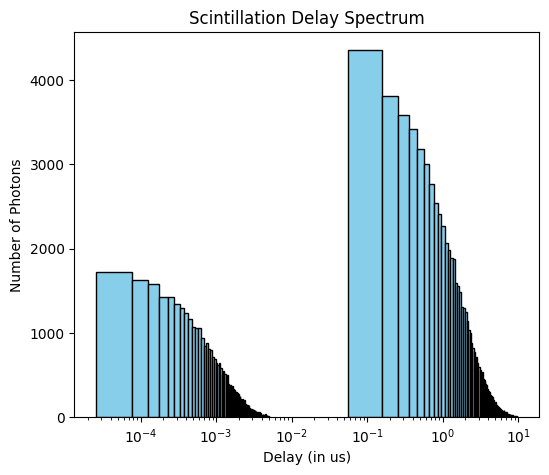

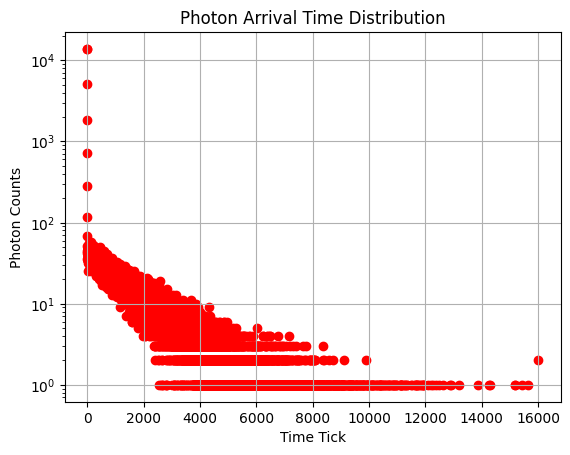

tensor([13782, 13579,  5079,  ...,     0,     0,     2])


In [129]:
nominal_singlet_fraction = 0.35
tau_s = 0.001 # in microseconds
tau_t = 1.530 # in microseconds
time_ticks = torch.arange(16000)
num_photons = int(1e5)
bin_spacing = 0.001 # microseconds per bin

# Plotting singlet & triplet decay PDFs
t = torch.linspace(0, 10, steps=1000)  # 0 to 10 us
singlet_pdf = (1 / tau_s) * torch.exp(-t / tau_s)
triplet_pdf = (1 / tau_t) * torch.exp(-t / tau_t)

# plt.figure(figsize=(8, 5))
# # plt.plot(t.numpy(), singlet_pdf.numpy(), label='Singlet PDF (τ_s = {:.1f} us)'.format(tau_s))
# plt.plot(t.numpy(), triplet_pdf.numpy(), label='Triplet PDF (τ_t = {:.1f} us)'.format(tau_t))
# plt.xlabel('Time (us)')
# plt.ylabel('Probability Density')
# plt.title('Exponential Decay Distributions')
# plt.legend()
# plt.grid(True)
# plt.show()

# Creating bin edges based on singlet & triplet distributions
# singlet_bins = np.linspace(0, 0.001, 50)
# triplet_bins = np.linspace(0.001, 10, 50)[1:]
# bins = np.concatenate((singlet_bins, triplet_bins))

# sanity check correct singlet/triplet fractions
singlet_bins = np.linspace(0, 0.005, 100)
triplet_bins = np.linspace(0.005, 10, 100)[1:]
bins = np.concatenate((singlet_bins, triplet_bins))

scintillation_delays, delay_counts = scintillation_model_sampling(num_photons=num_photons, bin_units = bin_spacing, time_ticks=time_ticks)
hist, bin_edges = np.histogram(scintillation_delays, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]
plt.figure(figsize=(6, 5))
plt.bar(bin_centers, hist, width=bin_widths, color='skyblue', edgecolor='black', align='edge')
plt.xscale('log')
plt.xlabel('Delay (in us)')
plt.ylabel('Number of Photons')
plt.title('Scintillation Delay Spectrum')
plt.show()

# hits per time tick
plt.figure()
# bin_centers = 0.5 * (time_ticks[:-1] + time_ticks[1:])
# plt.bar(bin_centers, delay_counts.numpy(), width=0.001, color='skyblue', edgecolor='black')

bin_centers = time_ticks
# plt.bar(bin_centers, delay_counts.numpy(), width=bin_spacing, color='skyblue', edgecolor='black', align='center')
# plt.step(bin_centers, delay_counts.numpy(), where='mid', color='red', linewidth=1.5)
plt.scatter(time_ticks, delay_counts.numpy(), color='red')


plt.yscale('log')
plt.xlabel('Time Tick')
plt.ylabel('Photon Counts')
plt.title('Photon Arrival Time Distribution')
plt.grid(True)
plt.show()

print(delay_counts)

In [117]:
print(delay_counts[:100])
print(len(delay_counts))

tensor([13590, 13598,  4985,  1838,   660,   316,   121,    80,    43,    33,
           50,    40,    38,    32,    37,    48,    44,    34,    50,    46,
           46,    38,    38,    43,    38,    39,    54,    25,    50,    33,
           38,    43,    40,    41,    49,    42,    38,    38,    38,    33,
           49,    43,    37,    37,    47,    34,    33,    37,    45,    39,
           35,    37,    40,    41,    40,    33,    37,    44,    36,    33,
           38,    38,    47,    36,    38,    37,    53,    30,    41,    38,
           39,    51,    46,    30,    35,    44,    30,    39,    47,    44,
           36,    41,    35,    46,    44,    47,    26,    34,    50,    42,
           48,    38,    28,    39,    46,    31,    36,    45,    45,    39])
16001


In [ ]:
# TODO NEXT:
# How do we apply this sampling strategy to multiple PMTs?